# Spring double pendulum
**Christoffer Aakre** <br>
**Github:** [`@christofferaakre`](https://github.com/christofferaakre)

## 1 Introduction
In this report, we will investigate and model numerically the motion of a spring double pendulum. See `Fig. 1` below:
<div align='center'>
<h4>
Fig. 1. Spring double pendulum.
</h4>
<img
src="diagrams/include/spring-double-pendulum.svg">
</div>

As can be seen from `Fig. 1` above, the system we are going to model is a double pendulum where the pendulum strings are elastic springs with spring constants $k_1$ and $k_2$. The equilibrium lengths of the springs are $L_1$ and $L_2$. We refer to the extended or compressed lengths of the springs as $d_1:=L_1 + r_1$ and $d_2:= L_2 + r_2$, where $r_1$ and $r_2$ are the displacements of the springs from their equilibrium length. The pendulum bobs have masses $m_1$ and $m_2$, and are located at positions $(x_1, y_1)$ and $(x_2, y_2)$ respectively. The angles between the springs and the horizontal are called $\theta_1$ and $\theta_2$.

For simplicity, we let $L_1 = 1$, and thus we only need one variable ($L_2$) to control the two lengths.

We will analyze this system using Lagrangian Mechanics, for which the usual procedure is the following:
1. Determine the number of degrees of freedom for the system, and its generalised coordinates
2. Write down the Lagrangian in terms of the generalised coordinates
3. Using the Lagrangian ([Wikipedia](https://en.wikipedia.org/wiki/Lagrangian_mechanics)), find the Euler Lagrange Equations ([Wikipedia](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation))
4. Solve the Euler Lagrange Equations, either analytically or numerically.

However, for this system the Euler Lagrange Equations will
be very complicated, so it becomes difficult to write them down, let alone derive them.
Thus, we set up the system using the
excellent symbolic computing library `sympy` ([docs](https://docs.sympy.org/latest/index.html)) to do this for us. Then, we will use `numpy` and `scipy`
to solve the equations numerically. We then investigate various extreme cases such as setting spring constants to $0$ or $\infty$, which reduce the system
to simpler systems like double or single pendulums, and then we compare our solutions to the well-known behaviour of these systems.
The regular double pendulum is known to be chaotic [1], so it is reasonable to assume that a spring pendulum
is also chaotic as it is a more complicated system. Finally, we compute the Lyapunov exponent ([Wikipedia](https://en.wikipedia.org/wiki/Lyapunov_exponent)) for some initial conditions.

**Note that this notebook was written in a `Python 3.7.9` environment, so if any issues are encountered when trying to
execute the notebook, please try this version of Python as your first troublehsooting step.**


## Methods
We start by importing the modules that we will use. We will need:
* `sympy` for symbolic computation
* `numpy` for `array`s, providing us with easy to use vectorised operations
* `scipy.integrate` for numerical computation, i.e. `scipy.integrate.solve_ivp`
* `scipy.signal` for signal analysis, in particular we use `scipy.signal.find_peaks` to calculate a period
* `scipy.optimize.curve_fit` for curve fitting
* `matplotlib.pyplot` for plotting
* `dill` to save and load data to disk. In particular, we will use `dill` to save and load our `sympy` functions and other
    things that take a while to compute so we don't need to run the 
    calculations every time we run the notebook
* `IPython.display.HTML` to display animations inline in the notebook
* `time.process_time` to time cells that take a long time to run
* `functools.partial` is used to constrain one argument of a function before it is used for a curve fit
* `utils` is the `utils.py` file present in the same directory as this notebook. It contains various helper functions I wrote whose implementation only distracts from the
    project, and whose names clearly indicate their function

In [1]:
import sympy as smp
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import dill
from IPython.display import HTML
from time import process_time
from functools import partial

from utils import make_animation, show_animation, deg_to_rad, rad_to_deg

# for convenience, since we will use np.pi many times in the code
pi = np.pi

# This is not relevant to the project, so there is no need to worry about what
# this line of code does. Nevertheless, if the reader is interested,
# refer to this discussion: https://github.com/uqfoundation/dill/issues/115
dill.settings['recurse'] = True

# if this variable is set to True, sympy will do its calculations and save
# the sympy functions to disk. If set to False, we simply load the sympy functions from disk
need_sympy = False

### 2.1 `sympy` setup
The first thing we need to do is set up our system in `sympy`. We do this by defining our variables and
the relations between the variables, and then telling `sympy` how to calculate the Lagrangian of the system symbolically.
From there, we can use other `sympy` methods to solve the system.
Note that a lot of the code will be wrapped in an `if` statement with a boolean variable explicitly defined as `True`
or `False` above, e.g. the `need_sympy` boolean in the cell below. This is done whenever there is a section of code that takes a long time to run. Instead of running
the code every time the notebook runs, we run it once, store the result, and only rerun it if we need to.
Note that running this notebook with all of the boolean flags set to `True` might take upwards of an hour because some of the calculations take a long time to do. As such,
keep all of the `need_calcs`, `need_sympy`, etc. booleans set to `False` unless you want to rerun these calculations for a specific reason. These booleans do not need to be set
to `True` even for the first time running these notebooks, as the required data files are already included with this notebook in the `data` directory.

We start by defining our variables. This is done in `sympy` using `sympy.symbols` ([docs](https://docs.sympy.org/latest/gotchas.html#symbols))


In [2]:
if need_sympy:
    t, m1, m2, g, k1, k2, L2 = smp.symbols('t m1 m2 g k_1 k_2 L_2')

$\theta_1$, $\theta_2$, $r_1$, and $r_2$ will all be functions of $t$, so we need to tell `sympy` this. We also
define the first and second time derivatives of these variables as they will be used later.
`sympy.diff` ([docs](https://docs.sympy.org/latest/tutorial/calculus.html)) takes the derivative symbolically.

In [3]:
if need_sympy:
    the1, the2, r1, r2 = smp.symbols(r'\theta_1, \theta_2, r_1, r_2', cls=smp.Function)

    the1 = the1(t)
    the1_d = smp.diff(the1, t)
    the1_dd = smp.diff(the1_d, t)

    the2 = the2(t)
    the2_d = smp.diff(the2, t)
    the2_dd = smp.diff(the2_d, t)

    r1 = r1(t)
    r1_d = smp.diff(r1, t)
    r1_dd = smp.diff(r1_d, t)

    r2 = r2(t)
    r2_d = smp.diff(r2, t)
    r2_dd = smp.diff(r2_d, t)

Next, $x_1$, $y_1$, $x_2$, and $y_2$ will be functions of $\theta_1$, $\theta_2$, $r_1$ and $r_2$:

In [4]:
if need_sympy:
    x1, y1, x2, y2 = smp.symbols('x_1, y_1, x_2, y_2', cls=smp.Function)

    x1 = x1(the1, r1)
    y1 = y1(the1, r1)
    x2 = x2(the1, r1, the2, r2)
    y2 = y2(the1, r1, the2, r2)

From Fig. 1, simple trigonometry tells us that
$$
x_1 = (1 + r_1) \cos \theta_1 \\
y_1 = -(1 + r_1) \sin \theta_1 \\
x_2 = x_1 + (L_2 + r_2) \cos\theta_2 \\
y_2 = y_1 - (L_2 + r_2) \sin\theta_2
$$
We also define the time derivatives of these variables using `sympy.diff` as they will be used later.

In [5]:
if need_sympy:
    x1 = (1 + r1) * smp.cos(the1)
    y1 = -(1 + r1) * smp.sin(the1)
    x2 = x1 + (L2 + r2) * smp.cos(the2)
    y2 = y1 - (L2 + r2) * smp.sin(the2)

    x1_d = smp.diff(x1, t)
    y1_d = smp.diff(y1, t)
    x2_d = smp.diff(x2, t)
    y2_d = smp.diff(y2, t)

The kinetic energy $T$ is given by
$$
T = \frac{1}{2} m_1 \left(\dot{x_1} ^ 2 + \dot{y_1} ^ 2 \right) + \frac{1}{2} m_2 \left(\dot{x_2} ^ 2 + \dot{y_2} ^ 2 \right),
$$
and the potential energy is given by
$$
V = m_1 g y_1 + m_2 g y_2 + \frac{1}{2}k_1 r_1^2 + \frac{1}{2} k_2 r_2^2.
$$
The Lagrangian $L$ is then given by $L = T - V$.

In [6]:
if need_sympy:
    T = 1/2 * m1 * (x1_d ** 2 + y1_d ** 2) +  1/2 * m2 * (x2_d ** 2 + y2_d ** 2)
    V = m1 * g * y1 + m2 * g * y2 + 1/2 * k1 * r1 ** 2 + 1/2 * k2 * r2 ** 2
    L = T - V

Now we need to find the Euler Lagrange Equations, which are of the form
$$
\frac{\partial L}{\partial q_j} - \frac{d}{dt}\left( \frac{\partial L}{\partial \dot{q_j}} \right) = 0,
$$
where $q_j$ is one of the generalised coordinates. We need one equation for every generalised coordinate. Our system has $4$ degrees of freedom with generalised coordinates $\theta_1$, $\theta_2$, $r_1$, and $r_2$, so we will need $4$ Euler Lagrange Equations. Trying to work this out by hand, one will quickly realise that this computation
is very complicated. Thankfully, `sympy` can do this for us quite easily. Below, we compute the left hand side (LHS) of the Euler Lagrange Equations:

In [7]:
if need_sympy:
    LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t)
    LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t)
    LE3 = smp.diff(L, r1) - smp.diff(smp.diff(L, r1_d), t)
    LE4 = smp.diff(L, r2) - smp.diff(smp.diff(L, r2_d), t)

    # the simplify method is used here because
    # sympy does not simplify automatically in order
    # to save time and resources
    LE1 = LE1.simplify()
    LE2 = LE2.simplify()
    LE3 = LE3.simplify()
    LE4 = LE4.simplify()

We can separate each of the 4 Euler Lagrange Equation into 2 coupled first order ODEs. Then, we can use ODE solvers like `scipy.integrate.solve_ivp`
to solve the resulting system of 8 first order ODEs. The process goes like this:

Consider the following second order differential equation:
$$
\frac{d^2 y}{dt^2} = F\left(t, y, \frac{dy}{dt} \right),
$$
where $F$ is an arbitrary function of $t$, $y$, and $\frac{dy}{dt}$. Then, we define $z_0 = y$ and $z_1 = \frac{dy}{dt}$, which gives us a coupled
system of two first order ODEs:

$$
\frac{d}{dt}z_0 = z_1, \\
\frac{d}{dt}z_1 = F(t, z_0, z_1).
$$

We have the left hand sides (LHS) of the Euler Lagrange Equations stored in variables `LE1`, `LE2`, `LE3`, and `LE4`. We can now use `sympy.solve`
([docs](https://docs.sympy.org/latest/modules/solvers/solvers.html#sympy.solvers.solvers.solve)) to solve them. This function assumes that the 
right side (RHS) of the equation is $0$, which it is because we wrote the Euler Lagrange Equation such that the RHS was $0$. 
We tell `sympy.solve` to solve the Euler Lagrange Equations for $\ddot{\theta_1}$, $\ddot{\theta_2}$, $\ddot{r_1}$, and $\ddot{r_2}$, and then we can solve them numerically.

In [8]:
if need_sympy:
    # simplify=False and rational=False make the solver run faster,
    # and we have no need for the symbolic representation of the solutions,
    # so there is no reason not to speed the process up a bit
    sols = smp.solve([LE1, LE2, LE3, LE4], (the1_dd, the2_dd, r1_dd, r2_dd),
                simplify=False, rational=False)

`sympy.solve` returns a `dict` containing $\ddot{\theta_1}$, $\ddot{\theta_2}$, $\ddot{r_1}$, and $\ddot{r_2}$, indexed by their variables names.

We now use `sympy.lambdify` ([docs](https://docs.sympy.org/latest/modules/utilities/lambdify.html)) to turn these expressions into lambda functions so that we can solve the equations numerically. Then, we use `dill.dump` ([docs](https://dill.readthedocs.io/en/latest/dill.html?highlight=dump#dill._dill.dump)) to save these functions to disk so that the notebook can be run multiple times without having to redo these calculations.

In [9]:
save_folder = 'data/'
if need_sympy:
    args = (m1, m2, k1, k2, g, L2, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d)
    
    # to get theta1_dd, theta2_dd, r1_dd, and r2_dd,
    # we need functions that takes all of the other variables
    # and parameters as an input and returns the right thing,
    # i.e. theta1_dd, theta_dd, r1_dd, or r1_dd

    # to get theta1_d, theta2_d, r1_d, and r2_d, we can just
    # make funtctions that take those quantities as the input
    # and returns it again, as the first derivatives of the 
    # generalised coordiantes are in our state, whereas the second
    # derivaties are not
    
    get_theta1_dd = smp.lambdify(args, sols[the1_dd])
    get_theta1_d = smp.lambdify(the1_d, the1_d)
    dill.dump(get_theta1_dd, open(save_folder + 'get_theta1_dd', 'wb'))
    dill.dump(get_theta1_d, open(save_folder + 'get_theta1_d', 'wb'))

    get_theta2_dd = smp.lambdify(args, sols[the2_dd])
    get_theta2_d = smp.lambdify(the2_d, the2_d)
    dill.dump(get_theta2_dd, open(save_folder + 'get_theta2_dd', 'wb'))
    dill.dump(get_theta2_d, open(save_folder + 'get_theta2_d', 'wb'))

    get_r1_dd = smp.lambdify(args, sols[r1_dd])
    get_r1_d = smp.lambdify(r1_d, r1_d)
    dill.dump(get_r1_dd, open(save_folder + 'get_r1_dd', 'wb'))
    dill.dump(get_r1_d, open(save_folder + 'get_r1_d', 'wb'))

    get_r2_dd = smp.lambdify(args, sols[r2_dd])
    get_r2_d = smp.lambdify(r2_d, r2_d)
    dill.dump(get_r2_dd, open(save_folder + 'get_r2_dd', 'wb'))
    dill.dump(get_r2_d, open(save_folder + 'get_r2_d', 'wb'))

If `need_sympy` is `False`, then we use `dill.load` ([docs](https://dill.readthedocs.io/en/latest/dill.html#dill._dill.load)) to load the functions from disk:

In [10]:
if not need_sympy:
    get_theta1_dd = dill.load(open(save_folder + 'get_theta1_dd', 'rb'))
    get_theta1_d = dill.load(open(save_folder + 'get_theta1_d', 'rb'))

    get_theta2_dd = dill.load(open(save_folder + 'get_theta2_dd', 'rb'))
    get_theta2_d = dill.load(open(save_folder + 'get_theta2_d', 'rb'))

    get_r1_dd = dill.load(open(save_folder + 'get_r1_dd', 'rb'))
    get_r1_d = dill.load(open(save_folder + 'get_r1_d', 'rb'))

    get_r2_dd = dill.load(open(save_folder + 'get_r2_dd', 'rb'))
    get_r2_d = dill.load(open(save_folder + 'get_r2_d', 'rb'))

### 2.2 Setting up the system for numerical solution
Now we will solve the Euler Lagrange Equations numerically using `scipy.integrate.solve_ivp` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)), which
is a function that can solve systems of ODEs given initial conditions.
We describe our system's state with a vector $\vec{S}$:
$$
\vec{S} = \left(\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2}, r_1, \dot{r_1}, r_2, \dot{r_2}\right).
$$
We need to define a function that takes the system's state and time $t$ as an input and returns the derivative $\dot{\vec{S}}$ of the system's state, defined as
$$
\dot{\vec{S}} = \sum_i \dot{S_i} \hat{r_i},
$$
where $\{S_i\}$ are the components of $S$ and $\{\hat{r_i}\}$ the basis vectors of the state space. For our system, we have
$$
\dot{\vec{S}} = \left(\dot{\theta_1}, \ddot{\theta_1}, \dot{\theta_2}, \ddot{\theta_2}, \dot{r_1}, \ddot{r_1}, \dot{r_2}, \ddot{r_2}, \right).
$$

In [11]:
def dSdt(t: float, S: np.ndarray) -> np.ndarray:
    """
    Returns the derivative of the given sate.
    
    t: time (float)
    S: state (array)
    
    returns: the derivative of the given state (float)
    """
    the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = S
    args = (m1, m2, k1, k2, g, L2, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d)
    return np.array([
        get_theta1_d(the1_d),
        get_theta1_dd(*args),
        get_theta2_d(the2_d),
        get_theta2_dd(*args),
        get_r1_d(r1_d),
        get_r1_dd(*args),
        get_r2_d(r2_d),
        get_r2_dd(*args)
        ])

We define a function `get_position` to conveniently get the $x$ and $y$ coordinates as a function of $\theta_1$, $\theta_2$, $r_1$, and $r_2$,
and functions `T` and `V` for the kinetic and potential energies.

In [12]:
def get_position(state: np.ndarray) -> np.ndarray:
    """
    Given the state, returns the positions of the
    two pendulums
    
    state: state (array)
    
    returns: positions of the two pendulums (array) 
    """
    the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
    
    x1 = (1 + r1) * np.cos(the1)
    y1 = -(1 + r1) * np.sin(the1)
    x2 = x1 + (L2 + r2) * np.cos(the2)
    y2 = y1 - (L2 + r2) * np.sin(the2)
    
    position = np.array([x1, y1, x2, y2])
    return position

In [13]:
def T(t: np.ndarray, state: np.ndarray, position: np.ndarray) -> np.ndarray:
    """
    Given time, state, and positions,
    calculate the kinetic energy over time of the system
    using np.diff (https://numpy.org/doc/stable/reference/generated/numpy.diff.html)
    to calculate derivatives
    
    t: Time (array)
    state: state (array)
    position: positions of the two pendulums (array)
    
    returns: kinetic energy over time (array)
    """
    x1, y1, x2, y2 = position
    dt = np.diff(t)
 
    x1_d = np.diff(x1) / dt
    y1_d = np.diff(y1) / dt 
    x2_d = np.diff(x2) / dt
    y2_d = np.diff(y2) / dt
      
    KE = 1/2 * m1 * (x1_d ** 2 + y1_d ** 2) + 1/2 * m2 * (x2_d ** 2 + y2_d ** 2)
   

    # since the kinetic energy function uses np.diff, it gets one less element
    # than the potential energy, which does not use np.diff.
    # in order to add the energies later they need to have the same size, so we just
    # duplicate the first entry. Since the size of these arrays will be very big,
    # the error introduced from this is completely negligible.
    KE = np.array([KE[0]] + list(KE))
    
    return KE

def V(t: np.ndarray, state: np.ndarray, position: np.ndarray) -> np.ndarray:
    """
    Given time, state and positions,
    calculate the potential energy over time of the system.
    
    t: Time (array)
    state: state (array)
    position: Position of the two pendulums (array)
    
    returns: Potential energy of the system over time (array)
    """
    x1, y1, x2, y2 = position
    the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
    PE = m1 * g * y1 + m2 * g * y2 + 1/2 * k1 * r1 ** 2 + 1/2 * k2 * r2 ** 2
    return PE

And a function `solve` to conveniently return the state and the $x$ and $y$ coordinates neatly packaged.
Note that we default the method for `scipy.integrate.solve_ivp` to `Radau` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.Radau.html)).
This is a 5th order implicit Runge-Kutta method. Because our equations are time symmetric, an implicit Runge-Kutta method is preferred over an explicit one [2].
Also, testing all the methods that `solve_ivp` can use ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)),
it was found that `Radau` performs the best, using the maximum variation of the total energy as a metric.

In [14]:
def solve(t: np.ndarray, y0: np.ndarray, m1: float, m2: float, k1: float, k2: float, L2: float, g=9.81, method: str='Radau') -> tuple:
    """
    Solves the system given time, initial state, and other parameters
    using scipy.integrate.solve_ivp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).
    By default, uses the Radau method (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.Radau.html).
    
    t: Time (array)
    y0: Initial state (array)
    m1: Mass of first pendulum (float)
    m2: Mass of second pendulum (float)
    k1: Spring constant of first pendulum (float)
    k2: Spring constant of second pendulum (float)
    L2: Length of second pendulum in terms of length of first pendulum, e.g. L2=2 means
    the second pendulum is twice as long as the first. (float)
    g: Strength of gravity (float). Defaults to 9.81.
    method: Method used by scipy.integrate.solve_ivp (str). Defaults to Radau.
    
    returns: State and position (tuple)
    """
    sol = solve_ivp(dSdt,
               t_span=(t[0], t[-1]),
               t_eval=t,
               y0=y0,
               method=method
               )

    t = sol.t
    state = sol.y
    position = get_position(state)
   
    return state, position

We define some functions that will be useful to make certain plots without
having to rewrite boilerplate code several times. Note that we will still make plots without
using these functions when we need something different.

In [15]:
width = 24
height = 3

def plot_energy(t: np.ndarray, state: np.ndarray, position: np.ndarray, xlim: tuple = None) -> None:
    """
    Plots the kinetic potential, and total energies against time
    on the same subplot. Also plots the relative variation
    of the toal energy on a separate subplot, and calculates the maximum
    variation of the total energy, and displays it neatly on the figure.
    Axis labels, titles, etc. are all taken care of.
    
    t: Time (array)
    state: state (array)
    position: Positions of the two pendulums (array)
    xlim: Optional argument specifying the xlim on the plot (tuple). 
    If left as the default (None), matplotlib will choose xlim itself
    
    
    returns: nothing (None) 
    """
    KE = T(t, state, position)
    PE = V(t, state, position)
    TE = KE + PE

    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    fig.set_figwidth(width)
    fig.set_figheight(height)

    max_variation_up = np.max(TE) / TE[0] - 1
    max_variation_down = 1 - np.min(TE) / TE[0]

    max_variation_percent = max(max_variation_up, max_variation_down) * 100

    for ax in axes:
        ax.set_xlabel('Time $t$')
        if xlim:
            ax.set_xlim(xlim)
    
    # plot kinetic, potential, and total energy
    axes[0].plot(t, KE, label='Kinetic energy')
    axes[0].plot(t, PE, label='Potential energy')
    axes[0].plot(t, TE, label='Total energy')
    axes[0].set_ylabel('Energy')
    axes[0].set_title('Time evolution of energy')
    axes[0].legend()

    # plot relative variation of total energy
    axes[1].plot(t, TE / TE[0], label='Relative variation of total energy')
    axes[1].set_title(f'Relative variation of total energy. Max variation = {max_variation_percent:.2f}%')

def plot_theta(t: np.ndarray, state: np.ndarray, position: np.ndarray, xlim: tuple = None):
    """
    Plots theta1 and theta2 against time on separate subplots. 
    Axes labels, titles, etc. are all taken care of.
    
    t: Time (array)
    state: state (array)
    position: Positions of the two pendulums (array)
    xlim: Optional argument specifying the xlim on the plot (tuple). 
    If left as the default (None), matplotlib will choose xlim itself
    
    returns: nothing (None) 
    """
    the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    fig.set_figwidth(width)
    fig.set_figheight(height)

    for ax in axes:
        ax.set_xlabel(r'Time $t$')
        if xlim:
            ax.set_xlim(xlim)

    # plot theta1 against time
    axes[0].plot(t, the1)
    axes[0].set_title(r'Time evolution of $\theta_1$')

    # plot theta2 against time
    axes[1].plot(t, the2)
    axes[1].set_title(r'Time evolution of $\theta_2$')

def plot_r(t: np.ndarray, sate: np.ndarray, position: np.ndarray, xlim: tuple = None):
    """
    Plots r1 and r2 against time on separate subplots. 
    Axis labels, titles, etc. are all taken care of.
    
    t: Time (array)
    state: state (array)
    position: Positions of the two pendulums (array)
    xlim: Optional argument specifying the xlim on the plot (tuple). 
    If left as the default (None), matplotlib will choose xlim itself
    
    returns: nothing (None) 
    """
    the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    fig.set_figwidth(width)
    fig.set_figheight(height)

    for ax in axes:
        ax.set_xlabel('Time $t$')
        if xlim:
            ax.set_xlim(xlim)
    
    # plot r1 against time
    axes[0].plot(t, r1)
    axes[0].set_title(r'Time evolution of $r_1$')

    # plot r2 against time
    axes[1].plot(t, r2)
    axes[1].set_title(r'Time evolution of $r_2$')

def plot_xy(t: np.ndarray, state: np.ndarray, position: np.ndarray, xlim: tuple = None) -> None:
    """
    Plots the trajectories in (x, y) space of the two pendulums 
    on separate subplots.
    Axis labels, titles. etc are all taken care of.
    
    t: Time (array) 
    state: state (array)
    position: Positions of the two pendulums (array)
    xlim: Optional argument specifying the xlim on the plot (tuple). 
    If left as the default (None), matplotlib will choose xlim itself
    
    returns: nothing (None)
    """
    x1, y1, x2, y2 = position
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    fig.set_figwidth(width)
    fig.set_figheight(height)
    
    for ax in axes:
        ax.set_xlabel(r'Horizontal direction $x$')
        ax.set_ylabel(r'Vertical direction $x$')
        if xlim:
            ax.set_xlim(xlim)
        
    # plot trajectory of first pendulum    
    axes[0].plot(x1, y1)
    axes[0].set_title('Trajectory of first pendulum')
    
    # plot trajectory of second pendulum    
    axes[1].plot(x2, y2)
    axes[1].set_title('Trajectory of second pendulum')

## 3 Results and Discussion
### 3.1 First solution
Now, let's define our constants, and solve the system for some arbitrarily chosen initial conditions.
We give our initial state in the form
$$
\vec{S_0} = \left(\theta_{10}, \dot{\theta}_{10}, \theta_{20}, \dot{\theta}_{20}, r_{10}, \dot{r}_{10}, r_{20}, \dot{r}_{20}  \right):
$$

In [16]:
t_min = 0
t_max = 20
dt = 1e-4
t = np.arange(t_min, t_max, dt)

g = 9.81
m1 = 1
m2 = 1
k1 = 10
k2 = 10
L2 = 1

initial_state = np.array([
   -0.89 * np.pi/2, # the1
   0, # the1_d
   -0.72 * np.pi/2, # the2
   0, # the2_d
   0, # r1
   5, # r1_d
   0, # r2
   5  # r2_d
])

state, position = solve(t=t, y0=initial_state, m1=m1, m2=m2, k1=k1, k2=k2, L2=L2)
the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
x1, y1, x2, y2 = position

Now, we use the some of the functions we defined earlier to make some plots, and see if our solution makes sense.

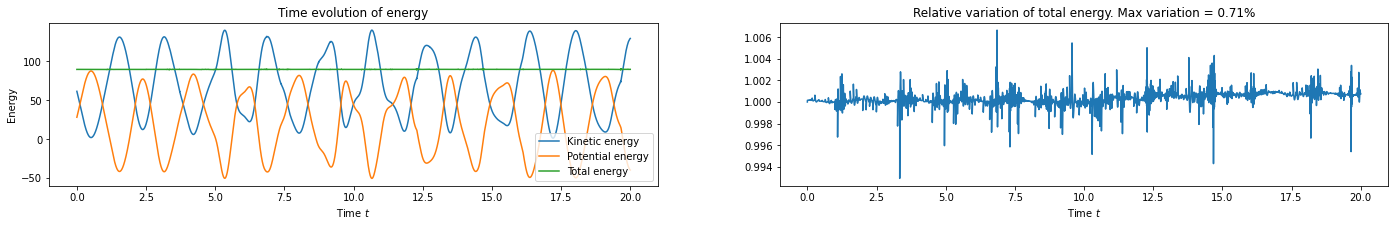

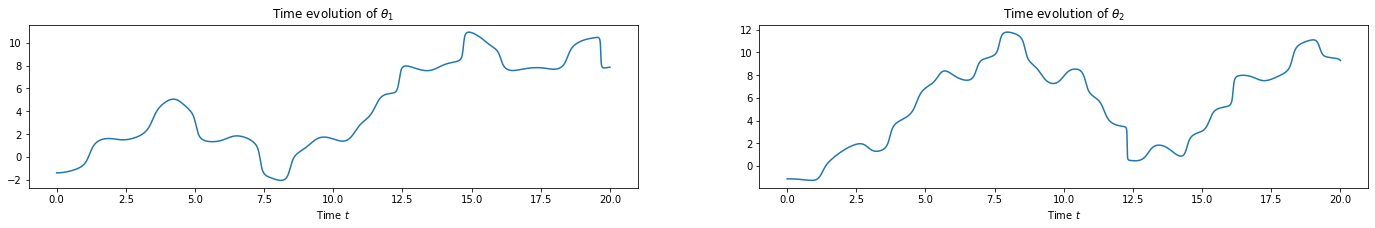

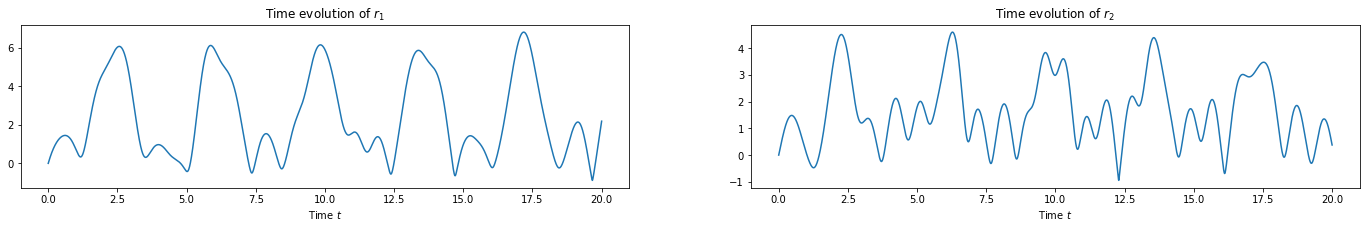

In [17]:
plot_energy(t, state, position)
plot_theta(t, state, position)
plot_r(t, state, position)

From the graphs, we see that we have energy conservation to within less than $1\%$. The kinetic and potential energies also show oscillatory motion even though it is not
perfectly sinusoidal. $r_1$ and $r_2$ also oscillate with time.

Let's also create an animation of the pendulum's motion and save it to `output/spring-double-pendulum.gif`:

In [18]:
animation_path = 'output/spring-double-pendulum.gif'
# only uncomment this when you need to remake the animation,
# because it takes a while to run
#make_animation(t=t, position=position, save_path=animation_path)

show_animation(animation_path)

The animation shows something that at least qualitatively looks like a spring double pendulum.
Next, we will look at some extreme cases of the initial conditions and parameters.

### 3.2 $k_1 \to \infty, k_2 \to \infty$: Regular double pendulum
We start by considering the limit as $k_1$ and $k_2$ go to infinity. In this limit, 
the spring restoring force diverges to infinity, so we should expect a regular double pendulum. When we make $k_1$ or $k_2$ very large, the spring forces become very large,
so `scipy.integrate.solve_ivp` can take a long time to find a solution. This also introduces large errors into the potential energy calculation.

Also, the cell below takes a while to run because $k_1$ and $k_2$ are so large, so we use `dill`
again to save our solution so we don't need to redo this calculation every time the notebook runs.

In [19]:
# we just pick 1000000 arbitrarily assuming it is a big enough number to 'approximate' infinity.
k1 = 1000000
k2 = 1000000
dt = 1e-4
t_max = 5
t = np.arange(t_min, t_max, dt)

need_double_pendulum_calulation = False
if need_double_pendulum_calulation:
    state, position = solve(t=t, y0=initial_state, m1=m1, m2=m2, k1=k1, k2=k2, L2=L2)
    dill.dump(state, open(save_folder + 'high-k-state', 'wb'))
    dill.dump(position, open(save_folder + 'high-k-position', 'wb'))
    
state = dill.load(open(save_folder + 'high-k-state', 'rb'))
position = dill.load(open(save_folder + 'high-k-position', 'rb'))

the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
x1, y1, x2, y2 = position

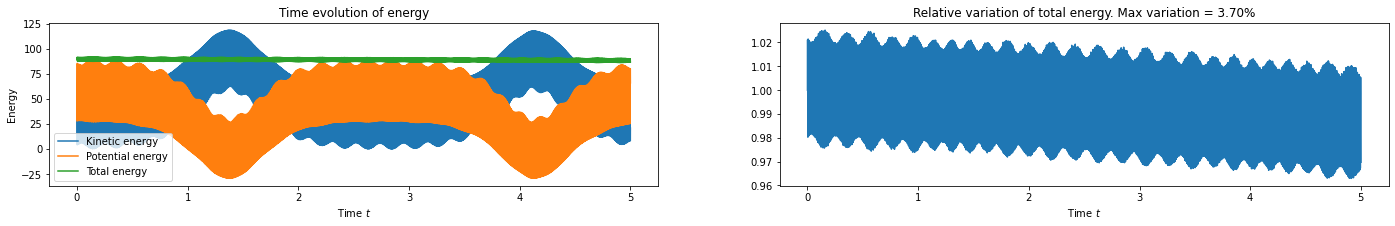

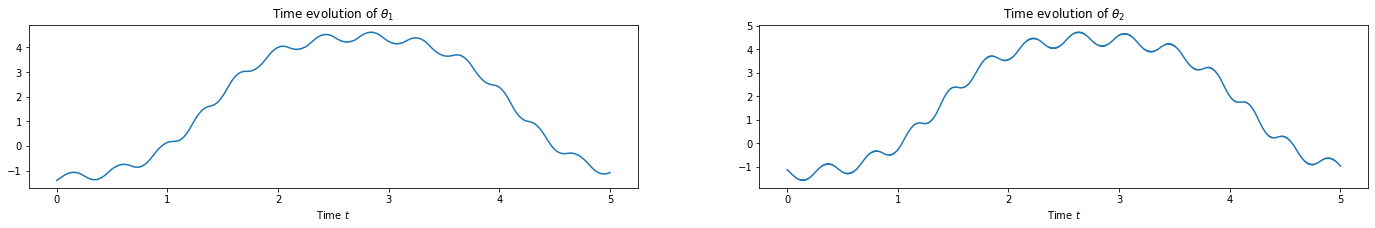

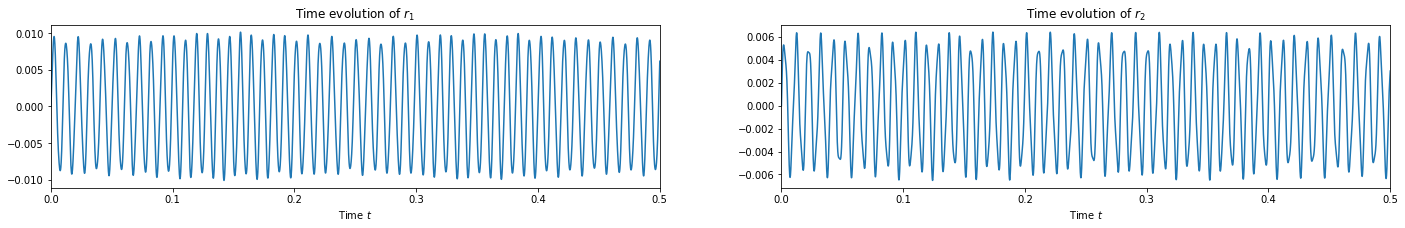

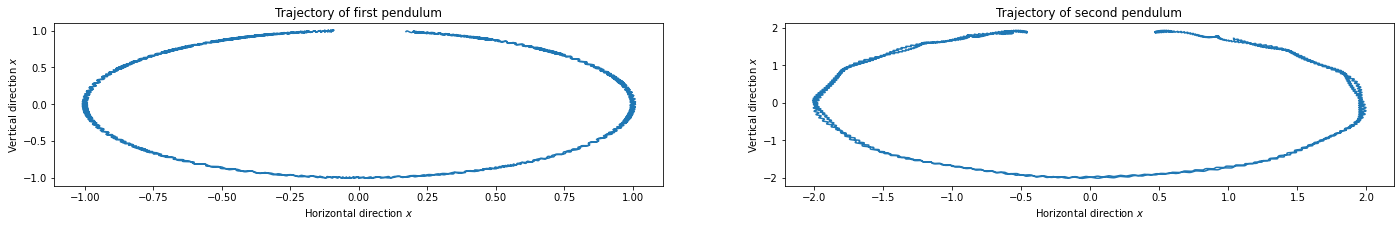

In [20]:
plot_energy(t, state, position)
plot_theta(t, state, position)

# Small xlim because r1 and r2 oscillate very quickly,
# so if we show the whole range it looks like a mess
plot_r(t, state, position, xlim=(0, 0.5))

plot_xy(t, state, position)

We clearly see periodic behaviour in the time evolution of $\theta_1$ and $\theta_2$. It also looks like $r_1$ and $r_2$ are oscillating. However, since we set $k_1$ and $k_2$ really high, we should expect that the springs do not contract or extend much at all. To confirm this, we can calculate the maximum variation of the extended/compressed length of the springs,
which are given by $d_1 = 1 + r_1$ and $d_2 = L_2 + r_2$ respectively.

In [21]:
d1 = 1 + r1
d2 = L2 + r2

print(f'The maximum variation of d1 is {(abs(np.max(d1 / 1)) - 1) * 100}%')
print(f'The maximum variation of f2 is {(abs(np.max(d2 / L2)) - 1) * 100}%')

The maximum variation of d1 is 1.012887624154235%
The maximum variation of f2 is 0.6415236714327532%


From experimentation, I found that the larger $k_1$ and $k_2$ we pick, the smaller the maximum variation of $d_1$ and $d_2$. However, that also means that the spring forces
can be massive even with tiny displacements, and this increases significant error into the potential energy calculation.
From the graph, we see that both angles are periodic, with period about $5$. This is consistent with our expectations, as despite the well-known chaotic behaviour of the
double pendulum, it is periodic for given initial conditions [1].
Finally, we can create an animation for these initial conditions and parameters.

In [22]:
animation_path = 'output/double.gif'
#make_animation(t=t, position=position, save_path=animation_path)
show_animation(animation_path)

The most interesting thing to note from this animation is that there is a peculiar 'shaking' phenomenon
present here. This is likely because we chose $k_1$ and $k_2$ to be large, and at $t=0$ there was a force (gravity)
pulling the springs down a little, and they start oscillating.

### 3.3 $k_1 \to \infty, k_2 = 0$: Regular single pendulum
Next, we briefly investigate the case where $k_2 = 0$. There will be no spring force on the second pendulum, so the only force acting on it will be gravity, 
so it will just be in free fall. Since the springs are ideal, the spring can extend infinitely. Thus, what we expect to see is the second pendulum falling down in free fall, and the
first pendulum should be completely unaffected. We can again set $k_1$ really high to easily verify our hypothesis, because then the first pendulum should simply
act like a regular pendulum. We use a small initial angle for $\theta_1$, because then we can compare it to the known model for a single pendulum which uses
the small angle approximation, and thus is only valid for small initial angles.

In [23]:
k1 = 100000
k2 = 0
t_max = 20
t = np.arange(t_min, t_max, dt)

initial_state = np.array([pi/2 - rad_to_deg(0.00000001), 0, pi/2 - rad_to_deg(0.00000002), 0, 0, 0, 0, 0])

need_calc = False
if need_calc:
    state, position = solve(t=t, y0=initial_state, m1=m1, m2=m2, k1=k1, k2=k2, L2=L2)
    dill.dump(state, open(save_folder + 'freefall-state', 'wb'))
    dill.dump(position, open(save_folder + 'freefall-position', 'wb'))
    
state = dill.load(open(save_folder + 'freefall-state', 'rb'))
position = dill.load(open(save_folder + 'freefall-position', 'rb'))
the1, the1_d, the2, the2_d, r1, r1_d, r2, r2_d = state
x1, y1, x2, y2 = position

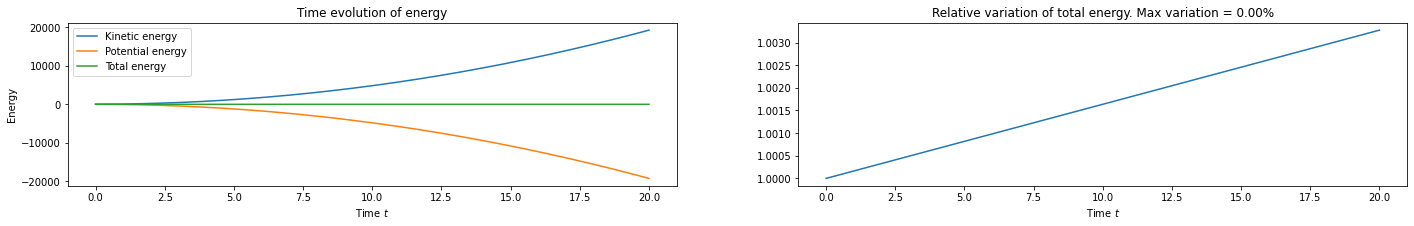

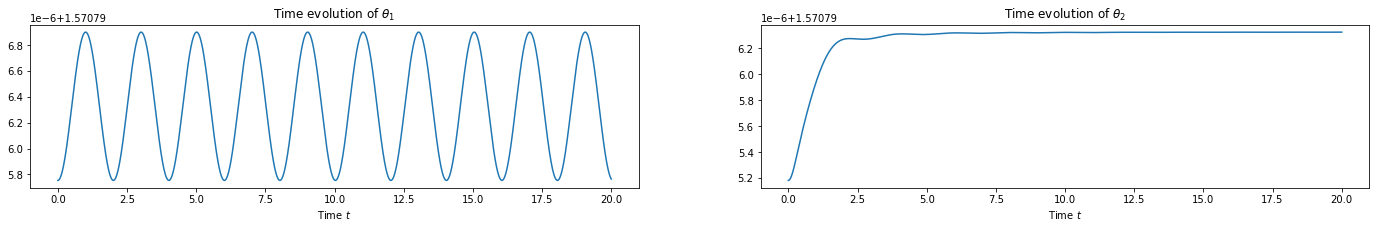

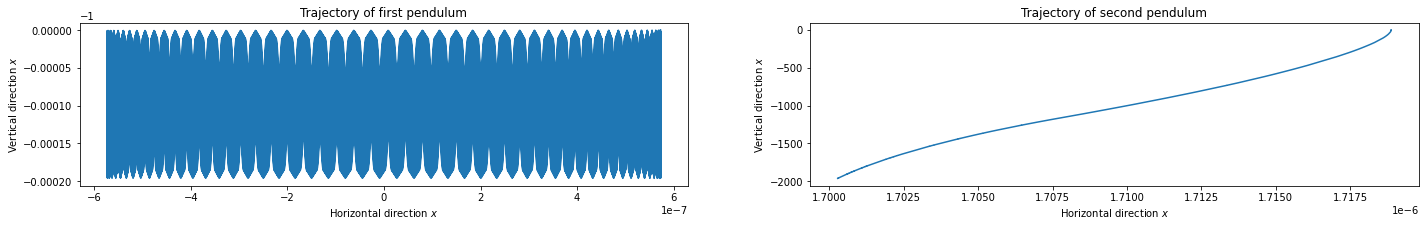

In [24]:
plot_energy(t, state, position)
plot_theta(t, state, position)
plot_xy(t, state, position)

We see that the kinetic and potential energies diverge to $\pm \infty$. This is because the second pendulum is in in free fall, so it keeps gaining speed, increasing the kinetic
energy, but since it falls, the gravitational potential energy becomes more and more negative. We also see that $\theta_1$  is clearly periodic. The formula for the period $T$ of a regular pendulum with small initial angle is $T = 2\pi \sqrt{\frac{L}{g}}$; We have $L_1 = 1$, thus
$T = 2\pi \sqrt{\frac{1}{g}}$ Let's calculate the period and compare it to this formula:

In [25]:
peaks, _ = find_peaks(the1)
period = np.diff(peaks) * dt
mean, std = np.mean(period), np.std(period)
expected = 2 * pi * np.sqrt(1 / g)

print(f'The period of the pendulum is {mean}±{std}')
print(f'The expected period was {expected}')
print(f'The error is {abs(expected - mean)}')

The period of the pendulum is 2.0061666666666667±4.714045207920265e-05
The expected period was 2.0060666807106475
The error is 9.998595601912186e-05


Our calculated period is close to the the theoretical value. Even with only 10 peaks to calculate the period,
the calculated period and the expected period agree to within about 2 standard deviations.
This is a good verification that our `sympy`-computed model works, as in both cases where it reduces to a double pendulum or single pendulum, our results match what we would expect.

Let's make an animation to see if our hypothesis about the free fall is correct. Because pendulum 2 goes into free fall, the range on $x_2$ on $y_2$ are much larger than those of 
$x_1$ and $y_1$. Thus if we show the entire trajectory on the animation, the motion of pendulum 1 will be too small to see. Therefore, we limit the $x$ and $y$ ranges, although this
means pendulum 2 will go off the screen.

In [26]:
animation_path = 'output/freefall.gif'
x_min = np.min(x1) - abs(np.min(x1))
x_max = np.max(x1) + abs(np.max(x1))

y_min = np.min(y1) - abs(np.min(y1))
y_max = np.max(y1) + abs(np.max(y1))

#make_animation(t=t, position=position, save_path=animation_path, xlim=(x_min, x_max), ylim=(y_min, y_max))
show_animation(animation_path)

As expected, we see a single pendulum with the second pendulum going off-screen in free-fall. 

### 3.4 Chaos in the spring double pendulum
Now, we will investigate the chaotic nature of the spring double pendulum. 
Chaotic behaviour means that a small change $\Delta x(t_0)$ in the initial conditions grows exponentially with time [1], i.e. 
$$
\Delta_x(t) \sim \Delta x(t_0) \exp(\lambda t),
$$
in the limit where $t \to \infty, \Delta x(t_0) \to 0$.
We will now attempt to calculate the Lyapunov exponent for certain initial conditions. Note that the Lyapunov exponent depends on the initial conditions, and as such is not unique.
A positive exponent indicates chaos, as even tiny $\Delta x(t_0)$ will grow exponentially, while a negative exponent means a stable system, as any initial separation, no matter how large, will converge to zero.
Note that $\Delta x$ is the *separation in phase space*, where our phase space is 
$(\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2}, r_1, \dot{r_1}, r_2, \dot{r_2})$. The word 'phase space' usually refers to a position-momentum space,
but here we have a position-velocity space for convenience, at the cost of some rigour. The separation $\Delta x$ between two states $\vec{S_1}$ and $\vec{S_2}$ is then
given by 

$$
\Delta x = \sqrt{\sum_{i} (S_1^i - S_2^i)^2}.
$$

We will calculate $\Delta x$ as a function of time for many pairs of two initial conditions, and then fit an exponential curve $A\exp(\lambda t)$ to 
the corresponding phase separation $\Delta x(t)$, with the constraint
that $A = \Delta x(t_0)$. If we obtain
a good fit this way, then  $\lambda$ will be the Lyapunov exponent. 
To get a good result, we need to approximate the limit as $t \to \infty$ and $\Delta x(t_0) \to 0$. To achieve, this we need to do two things:
1. Integrate the system over a large period of time.
2. Make the initial separation $\Delta x(t_0)$ very small.

In [27]:
def fit_func(lmbda, x, A):
    return A * np.exp(lmbda * x)

We will vary the initial value of $\theta_1$ to calculate the phase separation.
For each initial value of $\theta_1$, we calculate a second solution where the initial
value of $\theta_1$ is offset by some *small constant value*.
This ensures that the initial phase
separation $\Delta x(t_0)$ is always the same, so we can easily compare the phase
separations obtained.

In [28]:
k1 = 10
k2 = 10
# we decrease dt to decrease memory usage and
# make a bigger range for t to better approximate the limit
# as t goes to infinity
dt = 1e-2
t = np.arange(0, 50, dt)

max_theta = deg_to_rad(0.00001)

# The memory required to store these solutions is proportional to
# number of solutions * dt * t_max,
# where as the amount of time it takes to compute them is proportional
# to number of solutions * t_max
# with dt = 1e-2, t_max = 50, one solution takes about 8 seconds to compute and takes up
# about 600 bytes (0.6kB) of memory

# the range of initial theta1 values we will
# calculate solutions for
the1_range = np.linspace(0, max_theta, 100)

# initialising variables to store solutions in
states1 = np.zeros(shape=(len(the1_range), 8, len(t)))
states2 = np.zeros(shape=(len(the1_range), 8, len(t)))

need_calcs = False
if need_calcs:
    start = process_time()
    for i, the1 in enumerate(the1_range):
        initial_state[0] = the1
        
        # calculate solution
        state1, position1 = solve(t=t, y0=initial_state, m1=m1, m2=m2, k1=k1, k2=k2, L2=L2)
        states1[i] = state1
        
        # offset theta1 by small constant value
        the1_2 = the1 + max_theta
        initial_state[0] = the1_2
        
        # calcualate another solution with offset initial theta1 
        state2, position2 = solve(t=t, y0=initial_state, m1=m1, m2=m2, k1=k1, k2=k2, L2=L2)
        states2[i] = state2
            
    dill.dump(states1, open(save_folder + 'ly-states1', 'wb'))
    dill.dump(states2, open(save_folder + 'ly-states2', 'wb'))
    end = process_time()
    print(f'ran in {end - start} seconds')
        
states1 = dill.load(open(save_folder + 'ly-states1', 'rb'))
states2 = dill.load(open(save_folder + 'ly-states2', 'rb'))

ran in 1711.734375 seconds


Now we have two sets of states, `states1` and `states2`. We now calculate the phase differences between them,
and use the norm of `(states1 + states2) / 2` to calculate a relative phase separation, similar
to how one might plot the relative error of a calculation, where the relative error is defined as
`error / absolute value of quantity`. In this regard, the norm of `(states1 + states2) / 2` is our 'quantity',
and the phase separation is our error, only that in this case it is the 'error' that we are interested in.

In [29]:
state_diffs = abs(states1 - states2)

# calculating the phase separation
rms_diffs = np.sqrt(np.sum(state_diffs ** 2, axis=1))

# calculating the average of the two states used to calculate the phase
# separation.
avg_states = np.mean(np.array([states1, states2]), axis=0)

# Calculating the norm of the average state. This will be used
# to calculate a relative phase separation by dividing the phase
# separation by this
avg_norm = np.sqrt(np.sum(avg_states ** 2, axis=1))

# calculating relative phase separation by dividing by the norm of the
# average state, as explained in comment above
relative_seps = rms_diffs / avg_norm

We now make plots of the relative phase separations for each pair of solutions. Plotted on
a log y axis, we should expect straight lines since the phase separation is hypothesized to vary
exponentially with time.

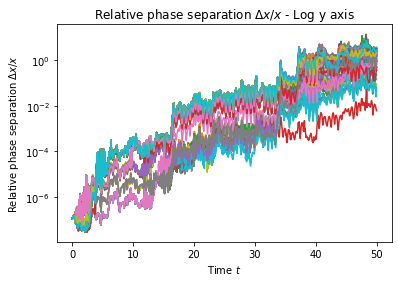

In [30]:
plt.xlabel(r'Time $t$')
plt.ylabel(r'Relative phase separation $\Delta x / x$')
plt.title(r'Relative phase separation $\Delta x / x$ - Log y axis')
for relative_sep in relative_seps:
    plt.semilogy(t, relative_sep)

From the plots above, we see that indeed the phase separation looks like an exponential curve,
as with a log y axis, it looks like straight lines could be a good fit for these curves. Now, we use `scipy.optimize.curve_fit` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)) to fit an exponential curve to the average of these curves:

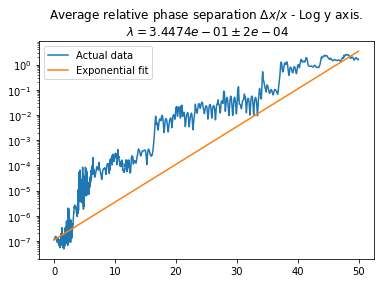

In [31]:
# Calculating the average relative phase separation
avg_sep = np.mean(relative_seps, axis=0)

# functools.partial gives us back a new function with
# one of the arguments set to a constant. In this case,
# we set A=avg_sep[0]
fit = partial(fit_func, A=avg_sep[0])

# See return signature of scipy.optimize.curve_fit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# This function returns the fit parameters and the estimated covariance
popt, pcov = curve_fit(fit, xdata=t, ydata=avg_sep)
lmbda = popt[0]

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# scipy docs say to do np.sqrt(np.diag(pcov)) to get standard deviation
# Note that the diagonlisation doesn't actually anything here since we only
# have one parameter, but we include it regardless
lmbda_err = np.sqrt(np.diag(pcov))[0]

plt.semilogy(t, avg_sep, label='Actual data')
plt.semilogy(t, fit(lmbda, t), label='Exponential fit')
plt.title(f'Average relative phase separation $\\Delta x / x$ - Log y axis. \n $\\lambda = {lmbda:.4e} \\pm {lmbda_err:.0e}$')
plt.legend()

We see that an exponential curve is a good fit to this data, and the exponent is positive, as expected. Now, we fit exponential curves
to each of the phase separations we calculated, and calculate the mean and standard deviation of $\lambda$. This is interesting,
because based on the standard deviation of $\lambda$, we can see if the Lyapunov exponent changes drastically in response to a small
change in initial conditions, or if the change in the exponent will be small if the change in initial conditions is small.

In [32]:
lmbdas = list()
lmbda_errs = list()

for relative_sep in relative_seps:
    fit = partial(fit_func, A=relative_sep[0])
    popt, pcov = curve_fit(fit, xdata=t, ydata=relative_sep)
    lmbda = popt[0]
    lmbda_err = np.sqrt(np.diag(pcov))[0]
    
    lmbdas.append(lmbda)
    lmbda_errs.append(lmbda_err)
    
print(f'mean lmbda: {np.mean(lmbdas)}, std. dev: {np.std(lmbdas)}')
#for lmbda, lmbda_err in zip(lmbdas, lmbda_errs):
    #print(f'λ = {lmbda:.5f} ± {lmbda_err:.5f}')

mean lmbda: 0.34012149413815956, std. dev: 0.018075811574967994


The small standard deviation in the $\lambda$s tells us that although the motion of each system is chaotic with respect to the initial conditions,
the Lyapunov exponent is not. That is, if we introduce a tiny change in the initial conditions, the change in
the Lyapunov exponent is also small.

Text(0.5, 1.0, 'Relative phase separation $\\Delta x / x$ \n $\\lambda = 3.19859e-01 \\pm 4e-04$')

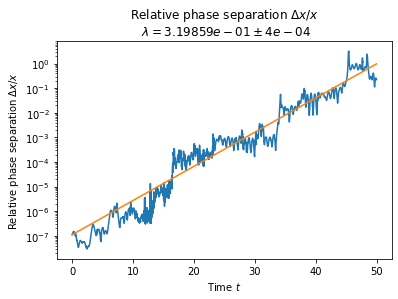

In [33]:
i = 0
plt.semilogy(t, relative_seps[i])
plt.semilogy(t, fit(lmbdas[i], t))
plt.xlabel(r'Time $t$')
plt.ylabel(r'Relative phase separation $\Delta x / x$')
plt.title(f'Relative phase separation $\\Delta x / x$ \n $\\lambda = {lmbdas[i]:.5e} \pm {lmbda_errs[i]:.0e}$')

## 5 Conclusion
With arbitrary initial conditions, the model behaves at least qualitatively like a spring double pendulum. In the limit where $k_1 \to \infty, k_2 \to \infty$,
the system simplifies to a regular double pendulum as expected. In the limit where $k_1 \to \infty, k_2 = 0$, the system reduces
to a simple pendulum, again as expected.
We calculated the Lyapunov exponent for a spring double pendulum with certain initial conditions to be $\lambda = 0.34 \pm 0.02$.
This exponent is positive, indicating a chaotic system. 
### 5.1 Strengths of the approach
The main strength of the `sympy` based approach is that very little algebra has to be done by hand. We just need to define our variables, do a little trigonometry,
and write down the formulas for the kinetic and potential energies, then `sympy` does the rest. This means that we can drastically change our system to something
completely different, and have a working model up and running in just a few seconds. The model is very general and flexible. In addition,
this approach allows us to solve problems for which the equations are too complicated to deal with by hand.
### 5.2 Weaknesses of the approach
The main weakness of the `sympy` focused approach used in this report is that the
`lambda` functions produced by `sympy.lambdify` are very slow to evaluate. Since `scipy.integrate.solve_ivp` needs to evaluate each of these
`lambda` functions many times, this makes the solutions very computationally intensive. A common way to speed up Python code with little effort
is to use the excellent just in time compiler (JIT) library `numba` ([docs](https://numba.readthedocs.io/en/stable/user/index.html)). However,
`numba` is unfortunately not compatible with the `lambda` functions produced by `sympy.lambdify`. See this Github issue for more information: https://github.com/sympy/sympy/issues/14714
It is possible to write a `numba` back end package for `sympy`; an example can be found here: https://github.com/jankoslavic/numbafy. It seems
like you can easily get several orders of magnitude faster computations this way, however I have no experience with writing such a back end myself and 
was unable to find any well-maintained projects that do this. Using Lagrangian mechanics, the equations are too simplified for an approach that
does not use symbolic computation. However, perhaps if a different paradigm like Hamiltonian mechanics is used, the equations might be simple enough
that they can be derived by hand, and then simply solved numerically. This would be faster since it does rely on `sympy.lambdify` and a JIT like
`numba` could easily be applied. However, I have not tried this, so I do not know the extent to which you would find success attempting this.

Another weakness is the 'shaking' phenomenon mentioned earlier in the report. If the spring constants $k_1$ and $k_2$ are large, and there is an initial force on the springs,
then the oscillation of the springs will introduce a lot of error into the potential energy calculation, and thus also the total energy calculation. It also
causes `solve_ivp` to take much longer to find a solution. The simplest way to avoid this would be
to have one model for the spring double pendulum, and then to simulate the regular double pendulum,
rather than taking the limit as $k_1 \to \infty, k_2 \to \infty$, you would just have a second model for the regular
double pendulum. The simplest way would be to simply derive the equations of motion of a double pendulum (no springs)
by hand (or find them on the internet: https://scienceworld.wolfram.com/physics/DoublePendulum.html) and then solve them numerically. Alternatively, `sympy` could still be used,
but the system would be simpler as it would just be a regular double pendulum rather than a more complicated system that simplifies to a double pendulum in a very
specific limit ($k_1 \to \infty, k_2 \to \infty$). The downside to this approach is that you need to manage two different models.  Another way to avoid this 'shaking' phenomenon is to set the initial conditions such that the initial force on the springs is zero, i.e. the spring forces
exactly counteract gravity, and the initial values of $\dot{r_1}$ and $\dot{r_2}$ to zero. This way, there would be no oscillation in the springs, and the whole problem is
circumvented.
However, the main reason
we investigated the limit as $k_1 \to \infty, k_2 \to \infty$ in the first place was to verify that our model makes sense checking a special case and comparing the results
to what we expect, and as such we did not do this.

The integration method used, `Radau`, is an implicit Runge-Kutta method, which is the preferred type of Runga-Kutta method for this type
of problem. However, there is still energy loss over time. In this report, there was never any significant energy leak over time because
the time range was purposefully limited to avoid this. If we want to simulate over time intervals several orders of magnitude longer,
we need a sympletic integrator to ensure that energy is conserved. A very informative resource on sympletic integrators
can be found here: https://scicomp.stackexchange.com/a/29154
### 5.3 Future work
There are a lot of interesting things left to investigate. For example:
* Investigate the maximum extension of the springs
* Look for attractors in phase space
* Investigate the effect of smoothly varying initial conditions and parameters, for example varying the
    initial value of $\theta_1$ from $0$ to $2\pi$.
* Setting the initial conditions such that the springs do not oscillate, and comparing to a regular double pendulum
* Using a sympletic integrator to avoid energy leak
* Finding a way to use `numba` or something similar on the `lamba` functions produced by `sympy.lamdbify` to significantly
    speed up the computation
* Investigate other systems using the same approach. For example, one could attempt to generalise the problem
    to n-tuple spring pendulum, where the system investigated here would be a special case where $n=2$.
    Ryan Rubenzahl has written a paper on the 'n pendulum': https://rrubenza.github.io/project/p235_npendulum/
* Simulate rigid body pendulums rather than point masses
* Use springs that can only extend up to a maximum length rather than ideal springs. This could potentially be modeled
    by having a piece-wise spring potential that has a discontinuous jump after a certain spring displacement

## 6 References
[1] Troy Shinbrot, et. al. *Chaos in a double pendulum*. American Association of Physics Teachers. (1992) Accessed 2021-05-01: http://yorke.umd.edu/Yorke_papers_most_cited_and_post2000/1992-04-Wisdom_Shinbrot_AmerJPhys_double_pendulum.pdf <br>
[2] Marek Basovn. *What's the difference between explicit and implicit Runge-Kutta methods?*. Mathematics Stack Exchange. Accessed 2021-05-09:<br>
https://math.stackexchange.com/a/1918752/627197